<a href="https://colab.research.google.com/github/RafayHussain103525/Firstrepo/blob/main/Multiclass_prediction_for_bipolar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d0167670a0a2df51fb9f134b2c73b367dc0506aab9ee16f8f8c5464d5ea4af27
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, GaussianNoise, Attention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
import shap

# Set seeds for reproducibility
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
def normalize_edu_column(df, edu_col):
    def range_to_midpoint(value):
        if isinstance(value, str):
            if ',' in value:
                start, end = map(int, value.split(','))
                return (start + end) / 2
            elif '-' in value:
                start, end = map(int, value.split('-'))
                return (start + end) / 2
        return float(value)

    df[edu_col] = df[edu_col].apply(range_to_midpoint)
    return df

def separate_blood_pressure(blood_pressure):
    try:
        systolic, diastolic = map(int, str(blood_pressure).split('/'))
        return systolic, diastolic
    except:
        return np.nan, np.nan

def preprocess_individual_file(
    condition_file_path,
    scores_df,
    sleep_health_df,
    is_condition=True
):
    print(f"Processing file: {condition_file_path}")
    # Load DataFrames
    df = pd.read_csv(condition_file_path)

    # Normalize edu column before processing
    scores_df = normalize_edu_column(scores_df, 'edu')

    # Extract file identifier
    file_identifier = os.path.splitext(os.path.basename(condition_file_path))[0]
    print(f"File identifier extracted: {file_identifier}")

    # Find corresponding score row
    file_number = int(file_identifier.split('_')[1]) - 1
    score_row = scores_df.iloc[file_number]
    print(f"Score row for {file_identifier} merged")

    # Select random row from sleep health dataset
    sleep_row = sleep_health_df.sample(n=1, random_state=1).iloc[0]
    print("Random row from sleep health dataset merged")

    # Timestamp Processing
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['week'] = df['timestamp'].dt.isocalendar().week

    # Cyclic features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
    df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
    df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

    # Drop original timestamp columns
    df = df.drop(columns=['hour', 'minute', 'week'])

    # Merge with score row
    for col, value in score_row.items():
        df[col] = value

    # Merge with sleep health row
    for col, value in sleep_row.items():
        df[col] = value

    # Handle Blood Pressure Separation
    if 'Blood Pressure' in df.columns:
        df['Systolic'], df['Diastolic'] = zip(*df['Blood Pressure'].apply(separate_blood_pressure))
        df = df.drop(columns=['Blood Pressure'])

    df = normalize_edu_column(df, 'edu')
    df = normalize_edu_column(df, 'age')

    # Categorical Variable Handling
    categorical_mappings = {
        'Gender': {'Male': 1, 'Female': 0},
        'Sleep Disorder': {'None': 0, 'Insomnia': 1, 'Sleep Apnea': 2},
        'Marriage': {1: 'Married', 2: 'Single'},
    }

    for col, mapping in categorical_mappings.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)

    # Columns to scale
    scale_columns = [
        'age', 'Sleep Duration', 'Quality of Sleep', 'activity', 'days',
        'Stress Level', 'Heart Rate', 'Daily Steps', 'edu', 'madrs1', 'madrs2', 'Systolic', 'Diastolic'
    ]

    # MinMax Scaling
    scaler = MinMaxScaler()
    for col in scale_columns:
        if col in df.columns:
            df[col] = scaler.fit_transform(df[[col]])

    # Outlier Handling
    numerical_cols = ['activity', 'Heart Rate', 'Sleep Duration', 'Stress Level']

    def handle_outliers(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return np.clip(series, lower_bound, upper_bound)

    for col in numerical_cols:
        if col in df.columns:
            df[col] = handle_outliers(df[col])

    # Rolling Window Features
    rows_per_day = 1440
    rolling_features = ['activity', 'Sleep Duration', 'Heart Rate']

    for feature in rolling_features:
        if feature in df.columns:
            df[f'{feature}_3d_avg'] = df[feature].rolling(window=3*rows_per_day, min_periods=1).mean()
            df[f'{feature}_7d_avg'] = df[feature].rolling(window=7*rows_per_day, min_periods=1).mean()
            df[f'{feature}_30d_avg'] = df[feature].rolling(window=30*rows_per_day, min_periods=1).mean()

    # Time Lagged Features
    lagged_features = ['activity', 'Sleep Duration']
    for feature in lagged_features:
        if feature in df.columns:
            for lag in [1, 2, 3]:
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

    drop_columns = ["number", "date", "Person ID", "Age", "Gender", "Occupation", "Physical Activity Level", "BMI Category"]
    existing_columns_to_drop = [col for col in drop_columns if col in df.columns]
    df = df.drop(columns=existing_columns_to_drop, errors='ignore')

    df.fillna(0, inplace=True)
    df['file_identifier'] = file_identifier
    print(f"File {file_identifier} processed successfully")
    return df

def process_all_files(
    condition_folder_path,
    control_folder_path,
    scores_path,
    sleep_health_path
):
    print("Starting processing of all files")

    scores_df = pd.read_csv(scores_path)
    sleep_health_df = pd.read_csv(sleep_health_path)

    all_processed_data = []

    # Get and sort condition files numerically
    condition_files = sorted(
        [f for f in os.listdir(condition_folder_path) if f.endswith('.csv')],
        key=lambda x: int(x.split('_')[1].split('.')[0])
    )

    # Process Condition Files in order
    for filename in condition_files:
        print(f"Processing condition file: {filename}")
        file_path = os.path.join(condition_folder_path, filename)
        processed_df = preprocess_individual_file(
            file_path,
            scores_df,
            sleep_health_df,
            is_condition=True
        )
        all_processed_data.append(processed_df)

    # Get and sort control files numerically
    control_files = sorted(
        [f for f in os.listdir(control_folder_path) if f.endswith('.csv')],
        key=lambda x: int(x.split('_')[1].split('.')[0])
    )

    # Process Control Files in order
    for filename in control_files:
        print(f"Processing control file: {filename}")
        file_path = os.path.join(control_folder_path, filename)
        processed_df = preprocess_individual_file(
            file_path,
            scores_df,
            sleep_health_df,
            is_condition=False
        )
        all_processed_data.append(processed_df)

    print("Combining all processed data")
    final_processed_data = pd.concat(all_processed_data, ignore_index=True)
    print("All files processed successfully")

    return final_processed_data

In [ ]:
# Define file paths
condition_folder_path = '/content/drive/MyDrive/data/condition'
control_folder_path = '/content/drive/MyDrive/data/control'
scores_path = '/content/drive/MyDrive/data/final_updated_scores_with_edu.csv'
sleep_health_path = '/content/drive/MyDrive/data/Sleep_health_and_lifestyle_dataset.csv'

# Process the files
data = process_all_files(
    condition_folder_path,
    control_folder_path,
    scores_path,
    sleep_health_path
)

# Display counts of `afftype`
afftype_counts = data['afftype'].value_counts()
print("Count of 1, 2, 0 in afftype:", afftype_counts)

def temporal_split_with_multiclass_undersampling(data, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    data = data.sort_values(by="timestamp")
    if 'timestamp' in data.columns:
        data = data.drop(columns=['timestamp'])

    data_0 = data[data['afftype'] == 0]
    data_1 = data[data['afftype'] == 1]
    data_2 = data[data['afftype'] == 2]

    def split_data(df, ratios):
        total_size = len(df)
        train_size = int(ratios[0] * total_size)
        val_size = int(ratios[1] * total_size)
        train = df.iloc[:train_size]
        val = df.iloc[train_size:train_size + val_size]
        test = df.iloc[train_size + val_size:]
        return train, val, test

    train_0, val_0, test_0 = split_data(data_0, [train_ratio, val_ratio, test_ratio])
    train_1, val_1, test_1 = split_data(data_1, [train_ratio, val_ratio, test_ratio])
    train_2, val_2, test_2 = split_data(data_2, [train_ratio, val_ratio, test_ratio])

    train_smallest_class_size = min(len(train_0), len(train_1), len(train_2))
    val_smallest_class_size = min(len(val_0), len(val_1), len(val_2))
    test_smallest_class_size = min(len(test_0), len(test_1), len(test_2))

    def undersample(data, target_size):
        if len(data) >= target_size:
            return resample(data, replace=False, n_samples=target_size, random_state=0)
        return data

    train_0 = undersample(train_0, train_smallest_class_size)
    train_1 = undersample(train_1, train_smallest_class_size)
    train_2 = undersample(train_2, train_smallest_class_size)

    val_0 = undersample(val_0, val_smallest_class_size)
    val_1 = undersample(val_1, val_smallest_class_size)
    val_2 = undersample(val_2, val_smallest_class_size)

    test_0 = undersample(test_0, test_smallest_class_size)
    test_1 = undersample(test_1, test_smallest_class_size)
    test_2 = undersample(test_2, test_smallest_class_size)

    train_data = pd.concat([train_0, train_1, train_2]).sample(frac=1, random_state=0)
    val_data = pd.concat([val_0, val_1, val_2]).sample(frac=1, random_state=0)
    test_data = pd.concat([test_0, test_1, test_2]).sample(frac=1, random_state=0)

    return train_data, val_data, test_data

def generate_sliding_windows(data, sequence_length, overlap):
    stride = int(sequence_length * (1 - overlap))
    sequences, labels = [], []
    for patient_id in data['file_identifier'].unique():
        patient_data = data[data['file_identifier'] == patient_id]
        features = patient_data.drop(columns=['afftype', 'file_identifier']).values
        target = patient_data['afftype'].values
        for start in range(0, len(features) - sequence_length + 1, stride):
            end = start + sequence_length
            sequences.append(features[start:end])
            labels.append(target[start:end][-1])
    return np.array(sequences), np.array(labels)

def clean_data(x_data):
    x_data = np.nan_to_num(x_data, nan=0.0, posinf=0.0, neginf=0.0)
    return x_data.astype(np.float32)

def prepare_data_for_lstm(data, sequence_length=30, overlap=0.5):
    train_data, val_data, test_data = temporal_split_with_multiclass_undersampling(data)
    x_train, y_train = generate_sliding_windows(train_data, sequence_length, overlap)
    x_val, y_val = generate_sliding_windows(val_data, sequence_length, overlap)
    x_test, y_test = generate_sliding_windows(test_data, sequence_length, overlap)
    return x_train, y_train, x_val, y_val, x_test, y_test, train_data, val_data, test_data

Starting processing of all files
Processing condition file: condition_1.csv
Processing file: /content/drive/MyDrive/data/condition/condition_1.csv
File identifier extracted: condition_1
Score row for condition_1 merged
Random row from sleep health dataset merged
File condition_1 processed successfully
Processing condition file: condition_2.csv
Processing file: /content/drive/MyDrive/data/condition/condition_2.csv
File identifier extracted: condition_2
Score row for condition_2 merged
Random row from sleep health dataset merged
File condition_2 processed successfully
Processing condition file: condition_3.csv
Processing file: /content/drive/MyDrive/data/condition/condition_3.csv
File identifier extracted: condition_3
Score row for condition_3 merged
Random row from sleep health dataset merged
File condition_3 processed successfully
Processing condition file: condition_4.csv
Processing file: /content/drive/MyDrive/data/condition/condition_4.csv
File identifier extracted: condition_4
Scor

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from itertools import cycle

def create_improved_model(input_shape, num_classes):
    regularizer = l1_l2(l1=0.02, l2=0.02)
    inputs = Input(shape=input_shape)
    x = GaussianNoise(0.1)(inputs)
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizer))(x)
    attention = Attention()([x, x])
    x = GlobalAveragePooling1D()(attention)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(32, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=regularizer)(x)
    return Model(inputs, outputs)

# Prepare and clean data
sequence_length = 60
overlap = 0.5
x_train, y_train, x_val, y_val, x_test, y_test, train_data, val_data, test_data = prepare_data_for_lstm(data, sequence_length, overlap)

x_train = clean_data(x_train)
x_val = clean_data(x_val)
x_test = clean_data(x_test)

y_train = to_categorical(y_train, num_classes=3).astype(np.float32)
y_val = to_categorical(y_val, num_classes=3).astype(np.float32)
y_test = to_categorical(y_test, num_classes=3).astype(np.float32)

model = create_improved_model(input_shape=(x_train.shape[1], x_train.shape[2]), num_classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

early_stopping = EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_auc', save_best_only=True, verbose=1)
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=532,
    callbacks=[early_stopping, model_checkpoint, lr_decay]
)



Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.3243 - auc: 0.4902 - loss: 43.2835
Epoch 1: val_auc improved from inf to 0.38127, saving model to best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 802ms/step - accuracy: 0.3250 - auc: 0.4907 - loss: 43.2705 - val_accuracy: 0.1331 - val_auc: 0.3813 - val_loss: 42.4154 - learning_rate: 1.0000e-04
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.3401 - auc: 0.5036 - loss: 43.0495
Epoch 2: val_auc did not improve from 0.38127
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 496ms/step - accuracy: 0.3409 - auc: 0.5047 - loss: 43.0445 - val_accuracy: 0.1234 - val_auc: 0.3853 - val_loss: 42.2594 - learning_rate: 1.0000e-04
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.3794 - auc: 0.5408 - loss: 42.7884
Epoch 3: val_auc did not improve from 0.38127
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step - accuracy: 0.3793 - auc: 0.5416 - loss: 42.7773 - val_accuracy: 0.1006 - val_auc: 0.3946 - val_loss: 42.1026 - learning_rate: 1.0000e-

Test Loss: 25.5480, Test Accuracy: 0.8521, Test AUC: 0.9609
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       108
           1       0.72      0.89      0.80       103
           2       0.88      0.65      0.75       100

    accuracy                           0.85       311
   macro avg       0.86      0.85      0.85       311
weighted avg       0.86      0.85      0.85       311



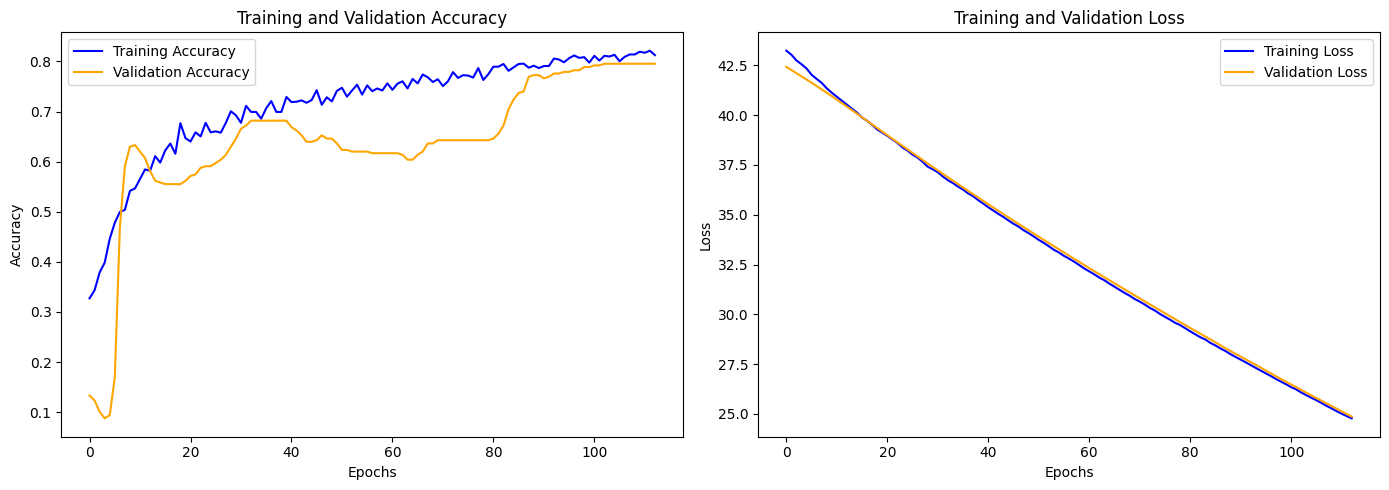

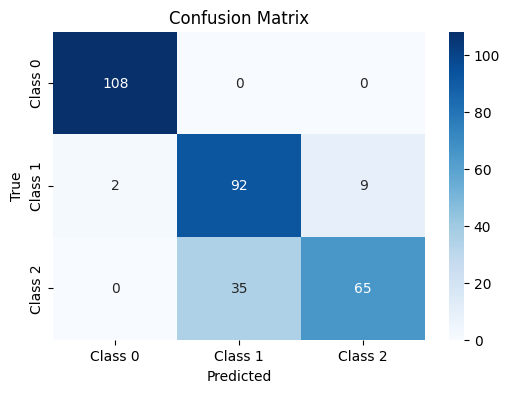

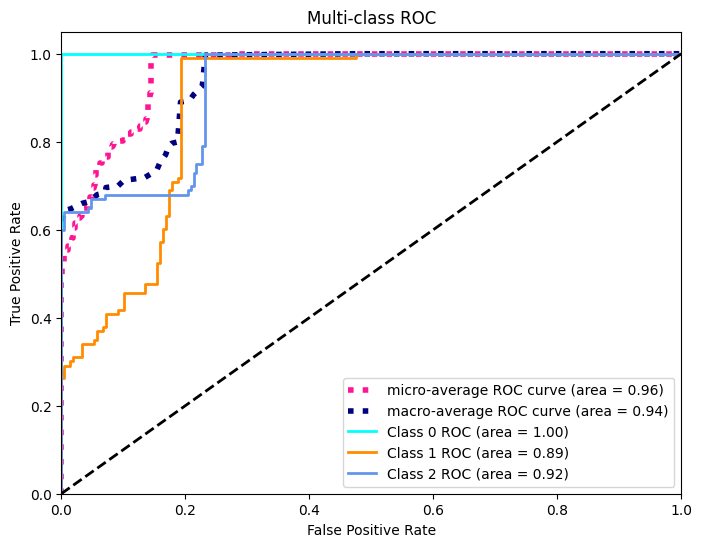

In [ ]:
# Evaluate on test set
results = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}, Test AUC: {results[2]:.4f}")

y_pred_proba = model.predict(x_test)
y_pred = y_pred_proba.argmax(axis=1)
y_true = y_test.argmax(axis=1)
print(classification_report(y_true, y_pred))

# Plot training and validation accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0","Class 1","Class 2"], yticklabels=["Class 0","Class 1","Class 2"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot ROC Curves for each class
# For multi-class, we will compute ROC per class and also micro/macro average
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

# Binarize the classes for ROC
# y_test is already one-hot encoded, same for y_pred_proba
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} ROC (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Multi-class ROC')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
lime_explainer = LimeTabularExplainer(
    training_data=x_train.reshape(x_train.shape[0], -1),  # Flatten the 3D array to 2D
    mode="classification",
    training_labels=np.argmax(y_train, axis=1),
    feature_names=[f"feature_{i}" for i in range(x_train.shape[1] * x_train.shape[2])],
    class_names=["Class 0", "Class 1", "Class 2"]
)
# Select a test sample and explain it for Class 2
test_sample_idx = 0
lime_explanation = lime_explainer.explain_instance(
    x_test[test_sample_idx].reshape(-1),  # Flatten the test sample to match the 2D input
    lambda x: model.predict(x.reshape(-1, x_train.shape[1], x_train.shape[2])),
    num_features=10,
    labels=[2]  # Focus on Class 2
)
# Set the matplotlib background color to white
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

# Display the LIME explanation inline in a Colab notebook
lime_explanation.show_in_notebook(show_table=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━

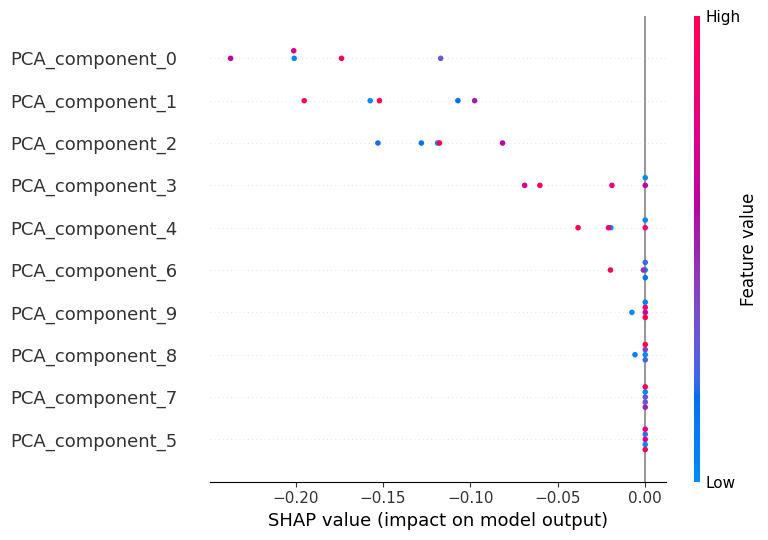

In [ ]:
from sklearn.decomposition import PCA
REDUCED_BACKGROUND_SAMPLES = 500  # down from 5000
TEST_SAMPLES = 5                  # fewer test samples
NSAMPLES = 50                     # fewer SHAP samples
# Adjust PCA components if possible
N_COMPONENTS = 10
# Define a more memory-friendly prediction function
def predict_reshaped(data, batch_size=64):
    predictions = []
    for i in range(0, data.shape[0], batch_size):
        batch = data[i:i + batch_size]  # (batch_size, n_components)
        # Inverse transform back to original dimension if needed
        # If possible, train model directly on PCA components to skip this step
        original_dim_batch = pca.inverse_transform(batch)  # shape: (batch_size, original_dim)
        reshaped_data = original_dim_batch.reshape(-1, x_train.shape[1], x_train.shape[2])
        preds = model.predict(reshaped_data)
        predictions.append(preds)
    return np.vstack(predictions)
# Limit background samples
num_background_samples = min(REDUCED_BACKGROUND_SAMPLES, x_train.shape[0])
background = x_train[:num_background_samples].reshape(num_background_samples, -1)
# Apply PCA
pca = PCA(n_components=N_COMPONENTS)
background_reduced = pca.fit_transform(background)
# Limit test samples
x_test_reshaped = x_test[:TEST_SAMPLES].reshape(TEST_SAMPLES, -1)
x_test_reduced = pca.transform(x_test_reshaped)
# Create the SHAP explainer
shap_explainer = shap.KernelExplainer(
    predict_reshaped,
    background_reduced,
    link='identity',
    l1_reg="num_features(5)"
)
# Compute SHAP values with fewer nsamples to reduce computation
shap_values = shap_explainer.shap_values(x_test_reduced, nsamples=NSAMPLES, silent=True)
# Handle multi-class output
selected_class_index = 0
if isinstance(shap_values, list):
    shap_values_for_class = shap_values[selected_class_index]
else:
    shap_values_for_class = shap_values[:, :, selected_class_index]
# Feature names (optional, can be omitted if memory is tight)
feature_names = [f"PCA_component_{i}" for i in range(x_test_reduced.shape[1])]
# Display summary plot (optional)
shap.summary_plot(
    shap_values_for_class,
    x_test_reduced,
    feature_names=feature_names,
    show=False
)
plt.show()

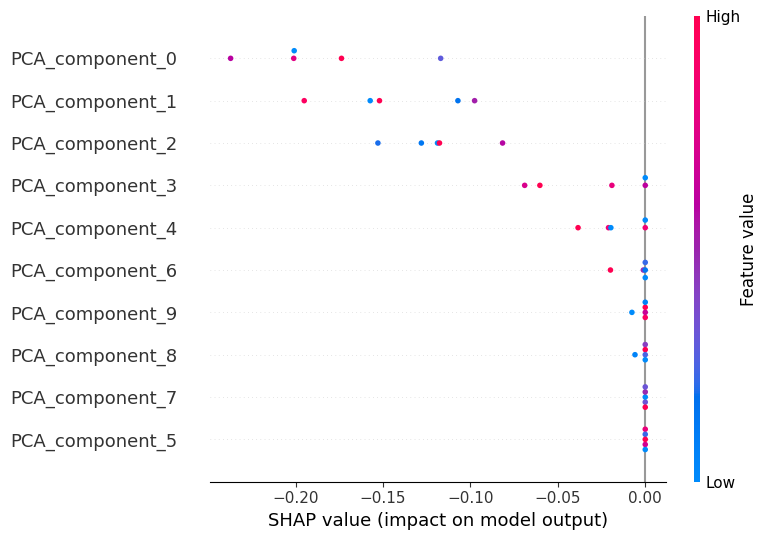

In [10]:
shap.summary_plot(
    shap_values_for_class,
    x_test_reduced,
    feature_names=feature_names,
    show=False
)
plt.show()